# Fundus Transfer‑Learning Pipeline

This notebook‑style script:
1. Installs & imports dependencies  
2. Sets a global random seed  
3. Clones RETFound_MAE & sets PYTHONPATH  
4. Downloads pretrained weights  
5. Detects your fundus dataset structure  
6. Instantiates & loads the pretrained ViT  
7. Inserts adapters for method=`'adapters'`  
8. Defines four transfer‑learning modes  
9. Runs a single experiment (`run_single`) and logs to CSV  
10. Visualizes learning curves & confusion matrix  

In [1]:
# 1) Install & import dependencies
import os, sys, random
SEED = 42
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    import timm, gdown, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix, classification_report
except ImportError:
    os.system(f"{sys.executable} -m pip install --quiet torch torchvision timm gdown pandas numpy matplotlib seaborn scikit-learn tqdm")
    import timm, gdown, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True

In [2]:
# ────────── Hyperparameters ──────────
NUM_EPOCHS    = 6           
BASE_LR       = 3e-5        
WEIGHT_DECAY  = 1e-4        
BATCH_SIZE    = 16

In [3]:
# 2) Clone RETFound_MAE & fix PYTHONPATH
def ensure_repo(name, url):
    if not os.path.isdir(name):
        print(f"Cloning {name} from {url}…")
        os.system(f"git clone {url} {name}")

ensure_repo("RETFound_MAE", "https://huggingface.co/open-eye/RETFound_MAE")
repo_path = os.path.join(os.getcwd(), "RETFound_MAE")
if not os.path.isdir(repo_path):
    raise FileNotFoundError(f"RETFound_MAE not found at {repo_path}")
sys.path.insert(0, repo_path)
print("✔ Added RETFound_MAE to PYTHONPATH")

✔ Added RETFound_MAE to PYTHONPATH


In [4]:
# 3) Download pretrained fundus weights
WEIGHTS = "RETFound_cfp_weights.pth"
if not os.path.isfile(WEIGHTS):
    print("Downloading pretrained fundus weights…")
    os.system(f"gdown --quiet --id 1l62zbWUFTlp214SvK6eMwPQZAzcwoeBE -O {WEIGHTS}")
print("✔ Model weights ready:", WEIGHTS)

✔ Model weights ready: RETFound_cfp_weights.pth


In [5]:
# 4) Detect dataset folder (handles nested color_fundus_eye/color_fundus_eye)
import os

# top‐level folder name (change if yours differs)
base = "color_fundus_eye"

# Look for either color_fundus_eye/train or color_fundus_eye/color_fundus_eye/train
if os.path.isdir(os.path.join(base, "train")):
    DATA_DIR = base
elif os.path.isdir(os.path.join(base, base, "train")):
    DATA_DIR = os.path.join(base, base)
else:
    raise FileNotFoundError(f"Cannot find 'train' under {base} or {base}/{base}")

train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

# Auto‐discover your classes from the folders
classes     = sorted(os.listdir(train_dir))
num_classes = len(classes)

# Quick sanity‐print
n_train = sum(len(files) for _,_,files in os.walk(train_dir))
n_test  = sum(len(files) for _,_,files in os.walk(test_dir))
print(f"DATA_DIR    = {DATA_DIR}")
print(f"Detected {num_classes} classes: {classes}")
print(f"Train dir   = {train_dir} ({n_train} images)")
print(f"Test dir    = {test_dir} ({n_test} images)")

DATA_DIR    = color_fundus_eye
Detected 10 classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
Train dir   = color_fundus_eye/train (12989 images)
Test dir    = color_fundus_eye/test (3253 images)


### 5) Instantiate & Load the Pretrained Vision Transformer (ViT) with Global Pooling and a Two-Layer MLP Head

This cell does the following:

1. **Loads** the pretrained RETFound checkpoint (backbone weights only).  
2. **Builds** a ViT model with **global average pooling** enabled.  
3. **Replaces** the original single-layer head with a **two-layer MLP head**.  
4. **Filters & loads** only the matching backbone weights, skipping any `head.*` parameters.  
5. **Interpolates** positional embeddings if needed.  
6. **Initializes** our new head from scratch.

In [6]:
import torch.nn as nn
import models_vit
from util.pos_embed import interpolate_pos_embed
from timm.layers import trunc_normal_

# — 5.0 Load the pretrained checkpoint into ckpt_model —
#    We only want the 'model' key, which contains the backbone weights.
checkpoint   = torch.load(WEIGHTS, map_location="cpu", weights_only=False)
ckpt_model   = checkpoint['model']

# — 5.1 Build the ViT backbone with global average pooling enabled —
#    global_pool=True replaces the usual CLS-token readout with an average over all patches.
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=1,       # placeholder, will override head immediately
    drop_path_rate=0.2,
    global_pool=True     # ← pool over all patch tokens
)

# — 5.2 Replace the original single-layer head with a 2-layer MLP head —
D = model.embed_dim      # e.g., 1024 for vit_large_patch16
model.head = nn.Sequential(
    nn.Linear(D, D // 2),    # bottleneck to half the dimension
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),         # small dropout for regularization
    nn.Linear(D // 2, num_classes)
)

# — 5.3 Filter out only the backbone weights (skip any head.*) —
sd = model.state_dict()
backbone_weights = {
    k: v for k, v in ckpt_model.items()
    if k in sd and not k.startswith('head.')
}

# — 5.4 Interpolate positional embeddings if shapes changed —
#    This handles the case where our new input size or pooling alters the pos_embed shape.
interpolate_pos_embed(model, ckpt_model)

# — 5.5 Load the filtered backbone weights (strict=False ignores missing head weights) —
msg = model.load_state_dict(backbone_weights, strict=False)
print("🔑 Missing keys when loading backbone (expected for new head):", msg.missing_keys)

# — 5.6 Initialize our new MLP head layers from scratch —
#    We reset parameters of any sub-module that supports reset_parameters().
for module in model.head:
    if hasattr(module, 'reset_parameters'):
        module.reset_parameters()

# Switch to evaluation mode by default (will be set to train() in the training loop)
model.eval()
print("✅ ViT backbone + 2-layer MLP head ready with global pooling enabled")

🔑 Missing keys when loading backbone (expected for new head): ['fc_norm.weight', 'fc_norm.bias', 'head.0.weight', 'head.0.bias', 'head.3.weight', 'head.3.bias']
✅ ViT backbone + 2-layer MLP head ready with global pooling enabled


### 6) Insert Adapter Modules for the “adapters” Transfer Method

In this step, we augment the pretrained Vision Transformer by adding a small “adapter” network inside its forward pass. During adapter-based fine-tuning:

1. **Adapter Architecture**  
   - A tiny **bottleneck** MLP that projects down from the embedding dimension `D` to `D/4`, applies a nonlinearity, then projects back to `D`.  
2. **Residual Connection**  
   - We wrap the original `forward_features` call and **add** the adapter output back to the backbone features, preserving most pretrained capacity.  
3. **Why Adapters?**  
   - Only the adapter parameters (plus final head) are trained—**all** other weights stay frozen—making fine-tuning very parameter-efficient.

In [7]:
from torch import nn

# 6.0 Compute embedding dimension and adapter bottleneck size
D = model.embed_dim           # e.g., 1024 for vit_large_patch16
adapter_dim = D // 4          # reduce to 256 by default

# 6.1 Define the adapter as a small MLP
model.adapter = nn.Sequential(
    nn.Linear(D, adapter_dim),  # project down
    nn.ReLU(inplace=True),      # nonlinearity
    nn.Dropout(0.1),            # light regularization
    nn.Linear(adapter_dim, D),  # project back up
)

# 6.2 Wrap the original forward_features to add the adapter output
_orig_forward = model.forward_features
def forward_with_adapter(x):
    feat = _orig_forward(x)           # original patch embeddings or pooled CLS
    return feat + model.adapter(feat) # residual add of adapter output

# 6.3 Monkey-patch the model to use the new forward
model.forward_features = forward_with_adapter

print("✅ Adapter inserted into Vision Transformer:", list(model.adapter))

# Set to eval mode by default; training loop will toggle train()/eval() as needed
model.eval()

✅ Adapter inserted into Vision Transformer: [Linear(in_features=1024, out_features=256, bias=True), ReLU(inplace=True), Dropout(p=0.1, inplace=False), Linear(in_features=256, out_features=1024, bias=True)]


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

## 7) DataLoaders & Transforms with Class-Balanced Sampling

To handle class imbalance in your fundus dataset, we:
1. Apply **train/validation transforms** (data augmentation on train only).  
2. Optionally **subsample** a fixed number of images (or use the full set).  
3. Compute **per-class frequencies** and invert them to get **class weights**.  
4. Build a **`WeightedRandomSampler`** so rare classes are drawn more often.  
5. Wrap everything in PyTorch **`DataLoader`**s.

This ensures each mini-batch has a balanced mix of classes, improving training stability.

In [8]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter

# a) Define data transforms
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.1,0.05),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# b) Control subset sizes (None = use full dataset)
TRAIN_SUBSET_SIZE = None    
VAL_SUBSET_SIZE   = None    

# c) Load (and optionally subsample) the training set
full_train = ImageFolder(train_dir, transform=train_tf)
print(f"Full TRAIN set size: {len(full_train)} images")

if TRAIN_SUBSET_SIZE and TRAIN_SUBSET_SIZE < len(full_train):
    idxs   = list(range(len(full_train)))
    labels = [full_train.samples[i][1] for i in idxs]
    train_idxs, _ = train_test_split(
        idxs,
        train_size=TRAIN_SUBSET_SIZE,
        random_state=SEED,
        stratify=labels
    )
    train_ds = Subset(full_train, train_idxs)
    print(f"Subsampled TRAIN → {len(train_ds)} images (balanced).")
else:
    train_ds = full_train

# d) Load (and optionally subsample) the validation set
full_val = ImageFolder(test_dir, transform=val_tf)
print(f"Full TEST set size:  {len(full_val)} images")

if VAL_SUBSET_SIZE and VAL_SUBSET_SIZE < len(full_val):
    vidxs   = list(range(len(full_val)))
    vlabels = [full_val.samples[i][1] for i in vidxs]
    val_idxs, _ = train_test_split(
        vidxs,
        train_size=VAL_SUBSET_SIZE,
        random_state=SEED,
        stratify=vlabels
    )
    val_ds = Subset(full_val, val_idxs)
    print(f"Subsampled VAL  → {len(val_ds)} images (balanced).")
else:
    val_ds = full_val

# e) Build DataLoaders with a WeightedRandomSampler
batch_size = BATCH_SIZE  # set in your hyperparameters cell

# Identify base dataset and selected indices
if isinstance(train_ds, Subset):
    base_ds = train_ds.dataset
    idxs    = train_ds.indices
else:
    base_ds = train_ds
    idxs    = list(range(len(base_ds)))

# Count samples per class
train_labels = [ base_ds.samples[i][1] for i in idxs ]
train_counts = Counter(train_labels)
print("Train class counts:")
for cls_idx, cnt in train_counts.items():
    print(f"  {classes[cls_idx]}: {cnt}")

# Compute inverse-frequency class weights
class_counts  = [ train_counts.get(i, 0) for i in range(num_classes) ]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

# Assign each sample its class weight
sample_weights = [ class_weights[ base_ds.samples[i][1] ] for i in idxs ]

# Create the sampler for balanced sampling
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(idxs),
    replacement=True
)

# Final DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"DataLoaders → Train: {len(train_ds)},  Val: {len(val_ds)}")

Full TRAIN set size: 12989 images
Full TEST set size:  3253 images
Train class counts:
  Central Serous Chorioretinopathy [Color Fundus]: 484
  Diabetic Retinopathy: 2755
  Disc Edema: 609
  Glaucoma: 2304
  Healthy: 2140
  Macular Scar: 1549
  Myopia: 1800
  Pterygium: 81
  Retinal Detachment: 600
  Retinitis Pigmentosa: 667
DataLoaders → Train: 12989,  Val: 3253


## 8) Transfer-Learning Configuration Helper

This function freezes or unfreezes parts of the Vision Transformer (ViT) backbone according to the chosen transfer-learning method:

1. **`linear_probe`**:  
   - Freeze **all** layers except the final classification head.  
   - Only the head’s weights are updated.

2. **`partial_ft`**:  
   - Freeze the **early** transformer blocks.  
   - Unfreeze the **last `partial_blocks`** transformer blocks plus the head.

3. **`full_ft`**:  
   - Unfreeze **all** model parameters for end-to-end fine-tuning.

4. **`adapters`**:  
   - Freeze the backbone **completely**.  
   - Unfreeze only the small **adapter** modules and the head.

Any other method name raises an error to prevent silent misconfiguration.


In [9]:
def apply_transfer_config(model, method, partial_blocks=4):
    """
    Configures which parameters are trainable based on the transfer method.
    
    Args:
        model:     The VisionTransformer with optional adapters inserted.
        method:    One of 'linear_probe', 'partial_ft', 'full_ft', or 'adapters'.
        partial_blocks: Number of final transformer blocks to unfreeze in 'partial_ft'.
    """
    # 1) Freeze all parameters by default
    for p in model.parameters():
        p.requires_grad = False

    # 2) Unfreeze the required parts for each method
    if method == 'linear_probe':
        # Only the classification head
        for p in model.head.parameters():
            p.requires_grad = True

    elif method == 'partial_ft':
        # The last `partial_blocks` transformer blocks + head
        for blk in model.blocks[-partial_blocks:]:
            for p in blk.parameters():
                p.requires_grad = True
        for p in model.head.parameters():
            p.requires_grad = True

    elif method == 'full_ft':
        # All parameters (end-to-end fine-tuning)
        for p in model.parameters():
            p.requires_grad = True

    elif method == 'adapters':
        # Only adapter layers and the head
        for name, p in model.named_parameters():
            if name.startswith('adapter') or name.startswith('head'):
                p.requires_grad = True

    else:
        raise ValueError(f"Unknown transfer-learning method '{method}'")

## 9) Single‐Run Experiment & Detailed CSV Logging

This cell defines the core function `run_single`, which orchestrates one full transfer‐learning experiment for a given method. It will:

1. **Re‐instantiate the Vision Transformer (ViT) backbone**  
   - Creates a fresh model instance to avoid cross‐contamination between experiments.  
   - Loads pretrained weights (excluding any classification head) via positional‐embedding interpolation.

2. **Optionally inject Adapters**  
   - If `method == 'adapters'`, we copy in the lightweight adapter module and override `forward_features` to sum adapter outputs.

3. **Freeze or unfreeze layers**  
   - Uses `apply_transfer_config` to set `requires_grad` flags according to the chosen method:  
     - **Linear Probe**: Only the head.  
     - **Partial Fine‐Tune**: Last few Transformer blocks + head.  
     - **Full Fine‐Tune**: All layers.  
     - **Adapters**: Only adapter + head.

4. **Move model to the compute device** (GPU if available, else CPU).  
   - Sets up **optimizer** (Adam) filtering only trainable parameters.  
   - Defines **loss** using `CrossEntropyLoss`, optionally weighted by inverse class frequencies for imbalance.

5. **Mixup/CutMix augmentation**  
   - Configured to apply to 50% of batches with label smoothing, enhancing robustness.

6. **Per‐epoch logging**  
   - Creates (or overwrites) a CSV file `phase3_exp{exp_no}_{method}_epochs.csv`.  
   - After each epoch, appends the training loss and validation accuracy for detailed curve analysis.

7. **Master summary logging**  
   - After all epochs, calculates total elapsed time.  
   - Appends a single row to `fundus_transfer_experiments.csv` summarizing:  
     - Experiment number (`exp_no`)  
     - Method name (`method`)  
     - Final validation accuracy  
     - Final training loss  
     - Total time in seconds  
     - Timestamp (YYYYMMDD_HHMMSS)

8. **Return values**  
   - Returns the fine‐tuned model (`tmp`) and its per‐epoch history dictionary for downstream visualization.

By encapsulating everything in `run_single`, you can easily loop over multiple methods, hyperparameter settings, or dataset subsets, and accumulate all metrics in a consistent, reproducible format.


In [10]:
from datetime import datetime
import csv, time, os, pandas as pd
import torch.nn as nn
from timm.data import Mixup
from tqdm import tqdm

# Path to the master summary CSV and its column order
SUMMARY_CSV    = "fundus_transfer_experiments.csv"
SUMMARY_FIELDS = ['exp_no', 'method', 'val_acc', 'train_loss', 'time_s', 'timestamp']

# Ensure the master CSV exists and has a header
if not os.path.isfile(SUMMARY_CSV):
    with open(SUMMARY_CSV, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=SUMMARY_FIELDS)
        writer.writeheader()

def run_single(exp_no, method):
    """
    Run one transfer‐learning experiment and log detailed metrics.

    Args:
        exp_no (int):   Identifier for this experiment (used in CSV).
        method (str):   One of ['linear_probe','partial_ft','full_ft','adapters'].

    Returns:
        tmp (nn.Module): The fine‐tuned model after NUM_EPOCHS.
        history (dict):  {'loss': [...], 'val_acc': [...]} per epoch.
    """

    # --- 1) Re‐instantiate & load pretrained backbone ---
    tmp = models_vit.__dict__['vit_large_patch16'](
        num_classes=num_classes,
        drop_path_rate=0.2
    )
    interpolate_pos_embed(tmp, ckpt_model)
    filtered_ckpt = {k: v for k, v in ckpt_model.items() if k in tmp.state_dict()}
    tmp.load_state_dict(filtered_ckpt, strict=False)

    # --- 2) Insert adapters if requested ---
    if method == 'adapters':
        tmp.adapter = model.adapter
        orig_forward = tmp.forward_features
        def forward_with_tmp_adapter(x):
            feat = orig_forward(x)
            return feat + tmp.adapter(feat)
        tmp.forward_features = forward_with_tmp_adapter

    # --- 3) Apply freeze/unfreeze configuration ---
    apply_transfer_config(tmp, method)

    # --- 4) Move model to device & set up optimizer + loss ---
    tmp = tmp.to(device)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, tmp.parameters()),
        lr=BASE_LR,
        weight_decay=WEIGHT_DECAY
    )
    crit = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # # --- Mixup/CutMix augmentation setup ---
    # mixup_fn = Mixup(
    #     mixup_alpha=0.2,
    #     cutmix_alpha=1.0,
    #     prob=0.5,
    #     switch_prob=0.5,
    #     mode='batch',
    #     label_smoothing=0.1,
    #     num_classes=num_classes
    # )

    # --- Prepare per‐epoch CSV file ---
    epoch_csv  = f"phase3_exp{exp_no}_{method}_epochs.csv"
    epoch_cols = ['epoch', 'train_loss', 'val_acc']
    pd.DataFrame(columns=epoch_cols).to_csv(epoch_csv, index=False)

    print(f"\n▶ Experiment #{exp_no} — method={method}")
    start_time = time.time()

    history = {'loss': [], 'val_acc': []}
    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- Training pass ----
        tmp.train()
        running_loss = 0.0
        for imgs, labels in tqdm(train_loader,
                                 desc=f"[{method}] E{epoch}/{NUM_EPOCHS} train",
                                 leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            # imgs, labels = mixup_fn(imgs, labels)  # apply Mixup/CutMix
            optimizer.zero_grad()
            loss = crit(tmp(imgs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        history['loss'].append(avg_loss)

        # ---- Validation pass ----
        tmp.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = tmp(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history['val_acc'].append(val_acc)

        # ---- Epoch summary print & log ----
        print(f"  Epoch {epoch}/{NUM_EPOCHS} ▶ "
              f"Train Loss: {avg_loss:.4f} — Val Acc: {val_acc:.4%}")

        pd.DataFrame([{
            'epoch': epoch,
            'train_loss': avg_loss,
            'val_acc': val_acc
        }]).to_csv(epoch_csv, mode='a', header=False, index=False)

    # --- Record elapsed time & master summary logging ---
    elapsed = time.time() - start_time
    summary = {
        'exp_no':     exp_no,
        'method':     method,
        'val_acc':    history['val_acc'][-1],
        'train_loss': history['loss'][-1],
        'time_s':     round(elapsed, 2),
        'timestamp':  datetime.now().strftime('%Y%m%d_%H%M%S'),
    }
    with open(SUMMARY_CSV, 'a', newline='') as f:
        csv.DictWriter(f, fieldnames=SUMMARY_FIELDS).writerow(summary)

    print(f">>> Logged exp#{exp_no} [{method}] → final Val Acc: {summary['val_acc']:.4%}")
    return tmp, history


## 10) Execute All Transfer‐Learning Experiments

In this step, we will:

1. **Prepare containers**  
   - `all_models`: to store the final fine-tuned model from each method.  
   - `all_histories`: to store per-epoch training and validation metrics for each method.

2. **Define the methods**  
   We will run four transfer-learning strategies:
   - **`linear_probe`**: freeze the backbone, train only the head.  
   - **`partial_ft`**: fine-tune the last few Transformer blocks + head.  
   - **`full_ft`**: fine-tune the entire network.  
   - **`adapters`**: keep backbone frozen but train lightweight adapter layers + head.

3. **Run the experiments in a loop**  
   For each `(exp_no, method)`, call `run_single`, log the final accuracy and loss, and save the resulting model and its history.

4. **Final confirmation**  
   After all experiments complete, check `fundus_transfer_experiments.csv` for the summary of results.


In [ ]:
import torch
import torch.nn as nn

# 1) Detect compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2) Prepare dictionaries to hold models and metrics
all_models     = {}
all_histories  = {}

# 3) List of transfer‐learning methods to try
methods = ['linear_probe', 'partial_ft', 'full_ft', 'adapters']

# 4) Loop over each method, run the experiment, and store results
for exp_no, method in enumerate(methods, start=1):
    print(f"\n=== Experiment #{exp_no}: {method} ===")
    model_ft, history = run_single(exp_no=exp_no, method=method)
    all_models[method]    = model_ft
    all_histories[method] = history

    # Print a quick summary of the final metrics
    final_acc  = history['val_acc'][-1]
    final_loss = history['loss'][-1]
    print(f">>> {method}: Final Val Acc = {final_acc:.4%}, Final Train Loss = {final_loss:.4f}")

# 5) Confirmation message
print("\n✅ All 4 experiments complete! Check 'fundus_transfer_experiments.csv' for aggregated results.")

## 11) Hyperparameter Grid Search

In this phase, we systematically explore combinations of key hyperparameters to find the best settings for each transfer‐learning method.  

**What we sweep:**  
- **Learning Rate (LR):** step size during optimization.  
- **Weight Decay (WD):** L2 regularization strength.  
- **Batch Size (BS):** number of samples per gradient update.

**Grid:**  
- LR ∈ {1e-4, 5e-5, 3e-5, 1e-5}  
- WD ∈ {1e-3, 1e-4, 1e-5}  
- BS ∈ {8, 16, 32}

**Procedure for each (lr, wd, bs, method):**  
1. **Update global hyperparameters** (`BASE_LR`, `WEIGHT_DECAY`, `BATCH_SIZE`).  
2. **Rebuild** `train_loader` and `val_loader` with the new batch size.  
3. **Run** `run_single(exp_no=100, method=method)` to fine-tune and evaluate.  
4. **Record** the final validation accuracy, training loss, and elapsed time.  
5. **Append** a row to `hp_tuning_results.csv`.

> **Defaults (used earlier in baseline runs):**  
> - `BASE_LR = 3e-5`  
> - `WEIGHT_DECAY = 1e-4`  
> - `BATCH_SIZE = 16`  

You can adjust the lists above to include more (or fewer) values.  
Run this cell **after** your baseline experiments (cell 10).

In [ ]:
import pandas as pd
from itertools import product
from datetime import datetime
from torch.utils.data import DataLoader
import time

# 1) Define the grid to search
lrs         = [1e-4, 5e-5, 3e-5, 1e-5]
wds         = [1e-3, 1e-4, 1e-5]
batch_sizes = [8, 16, 32]

# 2) Prepare the output CSV
HP_CSV    = "hp_tuning_results.csv"
hp_fields = ["lr","wd","batch_size","method","val_acc","train_loss","time_s","timestamp"]
pd.DataFrame(columns=hp_fields).to_csv(HP_CSV, index=False)

print("▶ Starting hyperparameter grid search…")
for lr, wd, bs in product(lrs, wds, batch_sizes):
    for method in methods:
        # 3) Update globals for this sweep
        BASE_LR      = lr
        WEIGHT_DECAY = wd
        BATCH_SIZE   = bs

        # 4) Rebuild DataLoaders
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  
                                  num_workers=4, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, 
                                  num_workers=4, pin_memory=True)

        # 5) Run the experiment
        print(f"\n--- HP Sweep: lr={lr}, wd={wd}, bs={bs}, method={method} ---")
        start_time = time.time()
        model_ft, history = run_single(exp_no=100, method=method)
        elapsed = time.time() - start_time

        # 6) Extract final metrics
        val_acc    = history["val_acc"][-1]
        train_loss = history["loss"][-1]

        # 7) Log the results
        row = {
            "lr": lr,
            "wd": wd,
            "batch_size": bs,
            "method": method,
            "val_acc": val_acc,
            "train_loss": train_loss,
            "time_s": round(elapsed, 2),
            "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S")
        }
        pd.DataFrame([row]).to_csv(HP_CSV, mode="a", header=False, index=False)

print("▶ Hyperparameter sweep complete! Results saved to", HP_CSV)



=== Results for full_ft ===
Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.25      0.89      0.39        19
                           Diabetic Retinopathy       0.93      0.59      0.72       106
                                     Disc Edema       0.47      1.00      0.64        23
                                       Glaucoma       0.75      0.30      0.43        89
                                        Healthy       0.53      0.79      0.63        82
                                   Macular Scar       0.83      0.25      0.38        60
                                         Myopia       0.73      0.74      0.73        69
                                      Pterygium       1.00      1.00      1.00         3
                             Retinal Detachment       0.81      0.96      0.88        23
                           Retinitis Pigmentosa       0.6

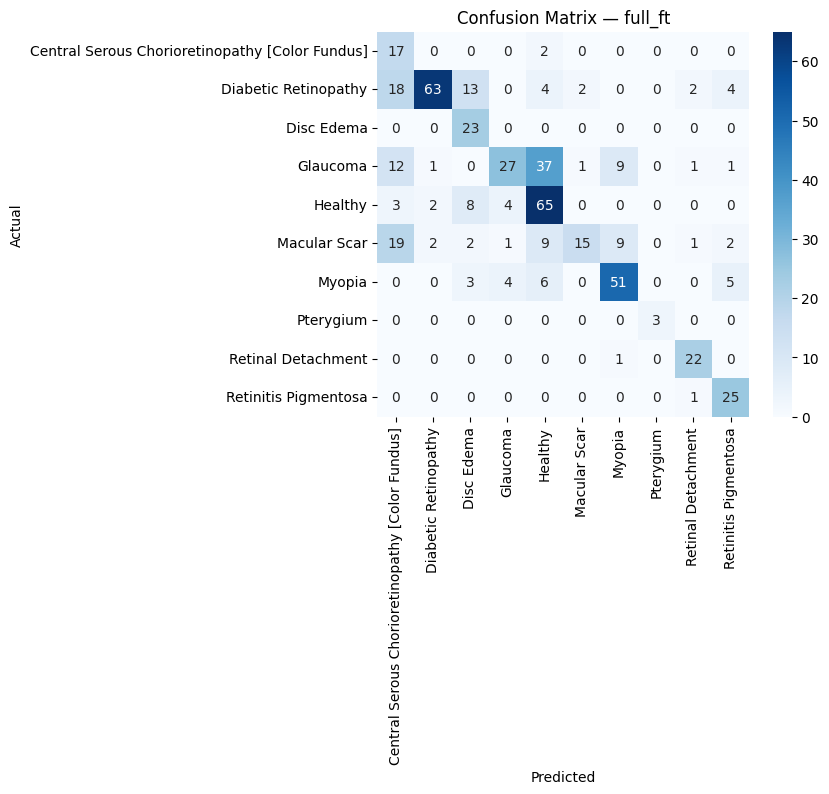

In [37]:
# 12) Per-method Confusion Matrices & Classification Reports
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for method, model_ft in all_models.items():
    print(f"\n=== Results for {method} ===")
    model_ft.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:      # or test_loader, whichever you prefer
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_ft(imgs).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # 1) Classification report
    print("Classification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=classes,
        zero_division=0
    ))

    # 2) Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=classes,
        yticklabels=classes,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix — {method}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [38]:
import torch

# Find which method gave the highest final validation accuracy
best_method = max(all_histories.items(),
                  key=lambda kv: kv[1]['val_acc'][-1])[0]
best_model  = all_models[best_method]
best_acc    = all_histories[best_method]['val_acc'][-1]

# Save its weights to disk
fname = f"best_model_{best_method}_{int(best_acc*10000):04d}.pth"
torch.save(best_model.state_dict(), fname)
print(f"✔ Saved best model ({best_method}) with val_acc={best_acc:.4%} to {fname}")

✔ Saved best model (full_ft) with val_acc=62.2000% to best_model_full_ft_6220.pth


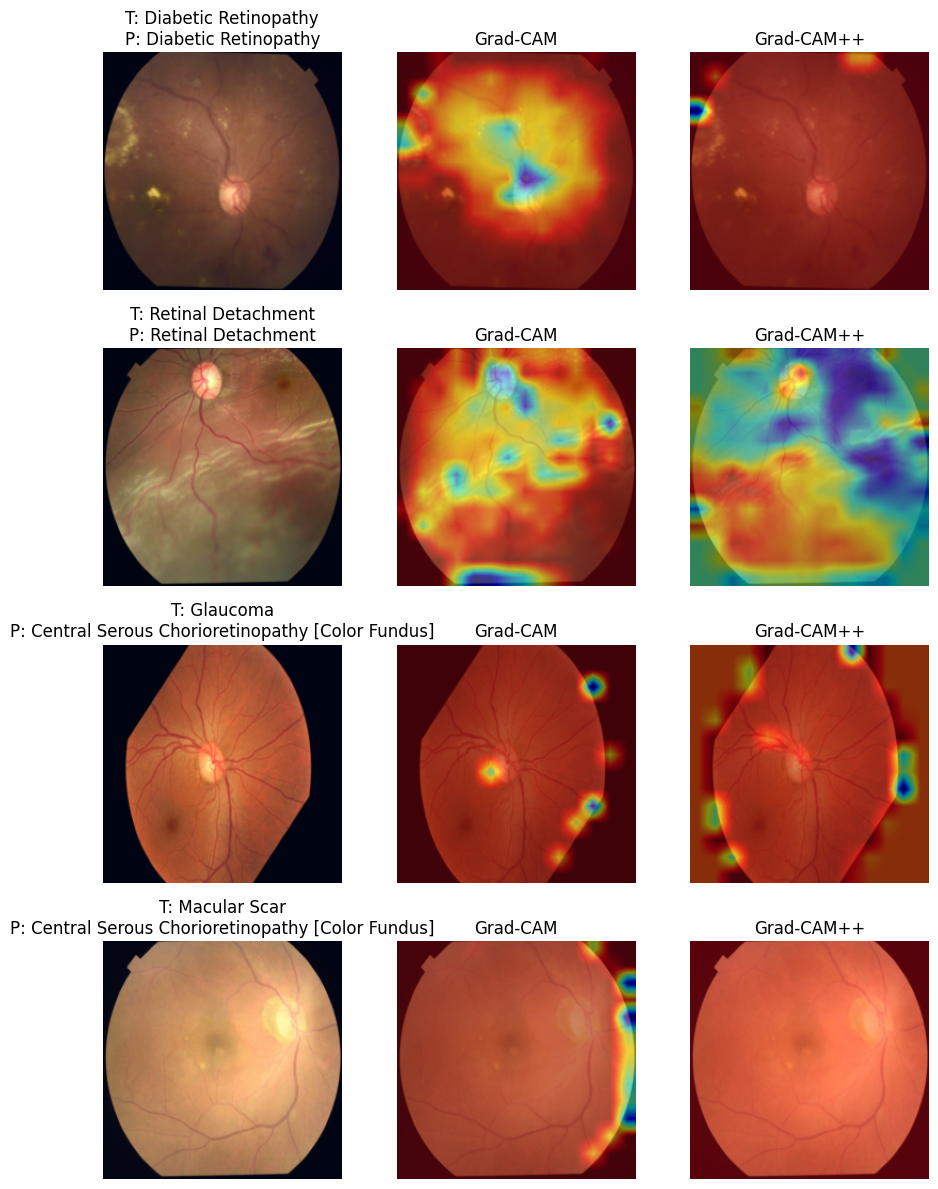

In [47]:

# Grad-CAM gallery: 2 correct + 2 incorrect examples (fixed colormap arg)
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

# 1) Cache all val images, labels & preds
all_imgs, all_labels, all_preds = [], [], []
best_model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = best_model(imgs)
        preds = logits.argmax(dim=1)
        all_imgs.extend(imgs.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 2) Split correct vs incorrect
correct_idxs   = [i for i,(l,p) in enumerate(zip(all_labels, all_preds)) if l==p]
incorrect_idxs = [i for i,(l,p) in enumerate(zip(all_labels, all_preds)) if l!=p]

# 3) Pick 2 of each
random.seed(42)
sel = random.sample(correct_idxs,   2) + random.sample(incorrect_idxs, 2)

# 4) Hook up CAMs on the conv layer that actually sees H×W
target_layer = best_model.patch_embed.proj
cam    = GradCAM(model=best_model,    target_layers=[target_layer])
cam_pp = GradCAMPlusPlus(model=best_model, target_layers=[target_layer])

# 5) Plot 4×3 grid: original / Grad-CAM / Grad-CAM++
fig, axes = plt.subplots(4, 3, figsize=(9, 12))
for row, idx in enumerate(sel):
    img_t = all_imgs[idx]     # tensor [3,224,224]
    lbl   = all_labels[idx]
    pr    = all_preds[idx]

    # prepare image for display
    img_np = img_t.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min())/(img_np.max()-img_np.min())

    # compute masks
    mask     = cam(input_tensor=img_t.unsqueeze(0).to(device))[0]
    mask_pp  = cam_pp(input_tensor=img_t.unsqueeze(0).to(device))[0]

    # col 1: original
    ax = axes[row, 0]
    ax.imshow(img_np)
    ax.set_title(f"T: {classes[lbl]}\nP: {classes[pr]}")
    ax.axis('off')

    # col 2: Grad-CAM
    ax = axes[row, 1]
    overlay = show_cam_on_image(img_np, mask, colormap=cv2.COLORMAP_JET)
    ax.imshow(overlay)
    ax.set_title("Grad-CAM")
    ax.axis('off')

    # col 3: Grad-CAM++
    ax = axes[row, 2]
    overlay2 = show_cam_on_image(img_np, mask_pp, colormap=cv2.COLORMAP_JET)
    ax.imshow(overlay2)
    ax.set_title("Grad-CAM++")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# --- 1) Prepare a place to store the weights ---
all_attn_weights = []

# --- 2) Define a forward-hook to grab the attention scores ---
def grab_attn(module, inp, out):
    # out is a tuple (attn_output, attn_weights)
    # attn_weights shape = [batch, num_heads, N, N]
    attn = out[1].detach().cpu()  
    all_attn_weights.append(attn)

# --- 3) Register the hook on each ViT block’s attention module ---
for blk in model.blocks:
    blk.attn.register_forward_hook(grab_attn)

model.eval()

# --- 4) Run one batch through to populate all_attn_weights ---
imgs, labels = next(iter(val_loader))
_ = model(imgs.to(device))  

# all_attn_weights now contains one tensor per block
# e.g. all_attn_weights[i].shape == [B, H, N, N]

# --- 5) Compute a single “roll-out” map for the CLS token across all heads & blocks ---
import numpy as np

# choose sample 0 in the batch
sample_maps = []
for block_map in all_attn_weights:
    # average over heads
    mean_heads = block_map[0].mean(dim=0)    # shape [N, N]
    # take the CLS token’s attention to all others:
    cls_attn  = mean_heads[0]               # shape [N]
    sample_maps.append(cls_attn.numpy())

# cumulative product (“attention rollout”):
rollout = np.eye(len(sample_maps[0]))
for m in sample_maps:
    rollout = rollout @ m
final_map = rollout[0,1:]   # discard the CLS→CLS element
final_map = final_map.reshape(patch_grid, patch_grid)  # e.g. 14×14

# --- 6) Upsample & overlay on the image ---
import cv2, matplotlib.pyplot as plt

mask = cv2.resize(final_map, (224,224), interpolation=cv2.INTER_CUBIC)
mask = (mask - mask.min())/(mask.max()-mask.min())

img_np = imgs[0].permute(1,2,0).cpu().numpy()
img_np = (img_np * [0.229,0.224,0.225] + [0.485,0.456,0.406]).clip(0,1)

heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
overlay = 0.3*heatmap[...,::-1]/255 + 0.7*img_np

plt.figure(figsize=(4,4))
plt.imshow(overlay)
plt.axis('off')
plt.title("Attention Rollout Overlay")
plt.show()


Now columns are: ['exp_no', 'method', 'val_acc', 'train_loss', 'time_s', 'timestamp']


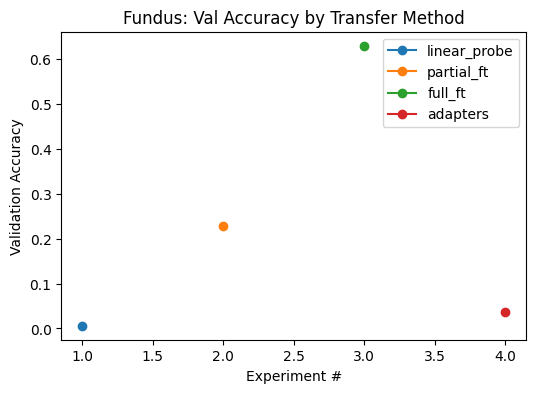

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

FIELDNAMES = ['exp_no','method','val_acc','train_loss','time_s','timestamp']

# force pandas to use our names, and treat the file as header-less
df = pd.read_csv("fundus_transfer_experiments.csv",
                 header=None,
                 names=FIELDNAMES)

print("Now columns are:", df.columns.tolist())
# should output ['exp_no','method','val_acc','train_loss','time_s','timestamp']

# And you probably want to drop the first row if it contained your old “header” as data:
if df.iloc[0].tolist() == FIELDNAMES:
    df = df.iloc[1:].reset_index(drop=True)

# Now plot normally
plt.figure(figsize=(6,4))
for m in df['method'].unique():
    sub = df[df['method']==m]
    plt.plot(sub['exp_no'], sub['val_acc'], marker='o', label=m)

plt.xlabel("Experiment #")
plt.ylabel("Validation Accuracy")
plt.title("Fundus: Val Accuracy by Transfer Method")
plt.legend()
plt.show()


←←← Confusion matrix for linear_probe →→→


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.00      0.00      0.00        19
                           Diabetic Retinopathy       0.00      0.00      0.00       106
                                     Disc Edema       0.00      0.00      0.00        23
                                       Glaucoma       0.00      0.00      0.00        89
                                        Healthy       0.00      0.00      0.00        82
                                   Macular Scar       0.00      0.00      0.00        60
                                         Myopia       0.00      0.00      0.00        69
                                      Pterygium       0.01      1.00      0.01         3
                             Retinal Detachment       0.00      0.00      0.00        23
                           Retinitis Pigmentosa       0.00      0.00      0.00        26

                   

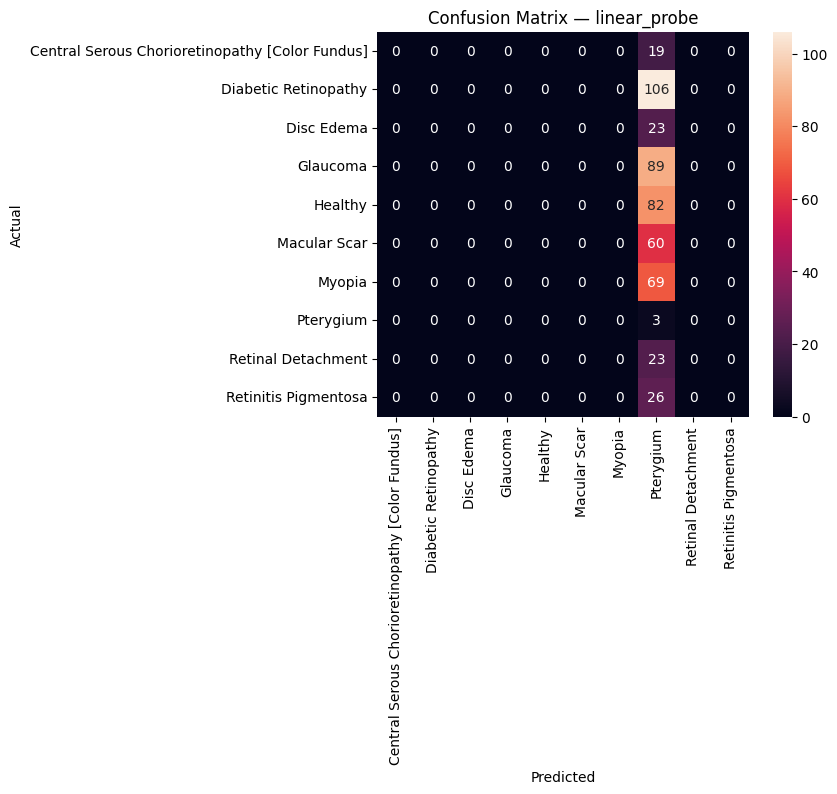

In [17]:
# Confusion matrix for the last run
from sklearn.metrics import confusion_matrix, classification_report

chosen = 'linear_probe'   # or pick linear_probe, partial_ft, full_ft
print(f"←←← Confusion matrix for {chosen} →→→")

model_to_plot = all_models[chosen]
model_to_plot.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        preds = model_to_plot(imgs).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title(f'Confusion Matrix — {chosen}')
plt.show()